In [ ]:
# --- 訓練 ---
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets
from torchvision.utils import save_image
from google.colab import drive


drive.mount('/content/drive', force_remount=True)

save_dir = "/content/drive/MyDrive/ddpm_experiment"
os.makedirs(save_dir, exist_ok=True)

save_path = os.path.join(save_dir, "ddpm_cat_model_heavy.pth")
ema_path  = os.path.join(save_dir, "ddpm_cat_model_heavy_ema.pth")
loss_curve_path = os.path.join(save_dir, "training_loss_heavy.npy")
loss_plot_path  = os.path.join(save_dir, "training_loss_curve_heavy.png")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

#參數
BETA_SCHEDULE = "cosine"   # "linear" or "cosine"
T_steps      = 1000
batch_size   = 32
total_epochs = 200
save_every   = 10
use_ema      = True
ema_decay    = 0.9999
lr           = 2e-4
weight_decay = 1e-4
base_channels = 128
time_dim = 256

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.benchmark = True

#CIFAR10-cats
transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])
dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
cat_indices = [i for i, label in enumerate(dataset.targets) if label == 3]
cat_dataset = Subset(dataset, cat_indices)
dataloader = DataLoader(cat_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = np.linspace(0, timesteps, steps)
    alphas_cumprod = np.cos(((x / timesteps) + s) / (1 + s) * np.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.tensor(np.clip(betas, 1e-8, 0.999), dtype=torch.float32)

def get_beta_schedule(name, timesteps, device):
    if name == "linear":
        return torch.linspace(1e-4, 0.02, timesteps).to(device)
    elif name == "cosine":
        return cosine_beta_schedule(timesteps).to(device)
    else:
        raise ValueError("Unknown beta schedule")

beta = get_beta_schedule(BETA_SCHEDULE, T_steps, device)
alpha = 1 - beta
alpha_bar = torch.cumprod(alpha, dim=0)

def q_sample(x0, t):
    noise = torch.randn_like(x0)
    alpha_bar_t = alpha_bar[t].view(-1,1,1,1)
    return alpha_bar_t.sqrt() * x0 + (1 - alpha_bar_t).sqrt() * noise

#模型
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, dim),
            nn.SiLU(),
            nn.Linear(dim, dim)
        )
    def forward(self, t):
        t = t.float().view(-1,1)
        return self.net(t)

def conv_block(in_ch, out_ch):
    return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, 3, padding=1),
        nn.GroupNorm(min(32, out_ch), out_ch),
        nn.SiLU()
    )

class HeavyUNet(nn.Module):
    def __init__(self, img_channels=3, base=64, time_dim=256):
        super().__init__()
        self.time_emb = TimeEmbedding(time_dim)
        self.time_mlp = nn.Sequential(nn.SiLU(), nn.Linear(time_dim, base*8))

        # encoder
        self.enc1 = conv_block(img_channels, base)
        self.down1 = nn.Conv2d(base, base*2, 4, 2, 1)
        self.enc2 = conv_block(base*2, base*2)
        self.down2 = nn.Conv2d(base*2, base*4, 4, 2, 1)
        self.enc3 = conv_block(base*4, base*4)
        self.down3 = nn.Conv2d(base*4, base*8, 4, 2, 1)
        self.enc4 = conv_block(base*8, base*8)

        self.bot = conv_block(base*8, base*8)

        self.up3 = nn.ConvTranspose2d(base*8, base*4, 4, 2, 1)
        self.dec3 = conv_block(base*8, base*4)
        self.up2 = nn.ConvTranspose2d(base*4, base*2, 4, 2, 1)
        self.dec2 = conv_block(base*4, base*2)
        self.up1 = nn.ConvTranspose2d(base*2, base, 4, 2, 1)
        self.dec1 = conv_block(base*2, base)

        self.final = nn.Conv2d(base, img_channels, 3, padding=1)

    def forward(self, x, t):
        t_emb = self.time_emb(t)
        t_emb = self.time_mlp(t_emb).unsqueeze(-1).unsqueeze(-1)

        e1 = self.enc1(x)
        d1 = self.down1(e1)
        e2 = self.enc2(d1)
        d2 = self.down2(e2)
        e3 = self.enc3(d2)
        d3 = self.down3(e3)
        e4 = self.enc4(d3)

        b = self.bot(e4 + t_emb)

        u3 = self.up3(b)            # base*4,16x16
        u3 = torch.cat([u3, e3], dim=1)
        u3 = self.dec3(u3)

        u2 = self.up2(u3)           # base*2,32x32
        u2 = torch.cat([u2, e2], dim=1)
        u2 = self.dec2(u2)

        u1 = self.up1(u2)           # base,64x64
        u1 = torch.cat([u1, e1], dim=1)
        u1 = self.dec1(u1)

        out = self.final(u1)
        return out

model = HeavyUNet(img_channels=3, base=base_channels, time_dim=time_dim).to(device)

#loss EMA
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.MSELoss()

class EMAHelper:
    def __init__(self, model, decay):
        self.decay = decay
        self.shadow = {}
        for n, p in model.named_parameters():
            if p.requires_grad:
                self.shadow[n] = p.detach().cpu().clone()
    def update(self, model):
        for n, p in model.named_parameters():
            if p.requires_grad:
                new = p.detach().cpu().clone()
                self.shadow[n].mul_(self.decay)
                self.shadow[n].add_(new * (1.0 - self.decay))
    def store(self, model):
        self.backup = {}
        for n, p in model.named_parameters():
            if p.requires_grad:
                self.backup[n] = p.detach().cpu().clone()
    def apply_to(self, model):
        for n, p in model.named_parameters():
            if p.requires_grad:
                p.data.copy_(self.shadow[n].to(p.device))
    def restore(self, model):
        for n, p in model.named_parameters():
            if p.requires_grad:
                p.data.copy_(self.backup[n].to(p.device))
        del self.backup

ema = EMAHelper(model, ema_decay) if use_ema else None

#resume
start_epoch = 1
epoch_losses = []
if os.path.exists(save_path):
    model.load_state_dict(torch.load(save_path, map_location=device))
    print("✅ Loaded model from", save_path)
else:
    print("⚙️ Start training from scratch")

if use_ema and os.path.exists(ema_path):
    ema_state = torch.load(ema_path, map_location='cpu')
    if isinstance(ema_state, dict):
        ema.shadow = ema_state
        print("✅ Loaded EMA shadow")

if os.path.exists(loss_curve_path):
    past_losses = np.load(loss_curve_path)
    start_epoch = len(past_losses) + 1
    epoch_losses = past_losses.tolist()
    print(f"🔁 Resuming from epoch {start_epoch}")
else:
    print("🔁 Starting from epoch 1")

#訓練
for epoch in range(start_epoch, total_epochs + 1):
    model.train()
    running_loss = 0.0
    for batch in dataloader:
        x0 = batch[0].to(device)
        t = torch.randint(0, T_steps, (x0.shape[0],), device=device)
        xt = q_sample(x0, t)
        noise_pred = model(xt, t)
        noise_true = (xt - alpha_bar[t].sqrt().view(-1,1,1,1) * x0) / (1 - alpha_bar[t]).sqrt().view(-1,1,1,1)

        loss = loss_fn(noise_pred, noise_true)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item()

        if use_ema:
            ema.update(model)

    avg_loss = running_loss / len(dataloader)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch:03d} | Avg Loss {avg_loss:.6f}")

#可視化
    if epoch % save_every == 0 or epoch == total_epochs:
        torch.save(model.state_dict(), save_path)
        if use_ema:
            torch.save(ema.shadow, ema_path)
        np.save(loss_curve_path, np.array(epoch_losses))
        print(f"💾 Saved model & loss at epoch {epoch}")

        try:
            plt.figure(figsize=(7,4))
            plt.plot(epoch_losses, label="Training Loss")
            plt.xlabel("Epoch"); plt.ylabel("MSE Loss")
            plt.title("DDPM Training Loss Curve"); plt.legend()
            plt.grid(True, alpha=0.3); plt.tight_layout()
            plt.savefig(loss_plot_path); plt.close()
        except Exception as e:
            print("⚠️ Could not save loss plot:", e)

        try:
            if use_ema:
                ema.store(model)
                ema.apply_to(model)
            model.eval()
            with torch.no_grad():
                sample_bs = min(batch_size, 8)
                img = torch.randn((sample_bs, 3, 64, 64), device=device)

                for i in reversed(range(T_steps)):
                    t_tensor = torch.full((img.shape[0],), i, device=device)
                    noise_pred = model(img, t_tensor)
                    alpha_t = alpha[i]
                    alpha_bar_t = alpha_bar[i]
                    beta_t = beta[i]
                    img = (1/alpha_t.sqrt()) * (img - (beta_t / (1 - alpha_bar_t).sqrt()) * noise_pred)
                    if i > 0:
                        img += torch.sqrt(beta_t) * torch.randn_like(img)
                img = (img.clamp(-1,1) + 1) / 2
                sample_path = os.path.join(save_dir, f"sample_epoch_{epoch}.png")
                save_image(img, sample_path)
                print("🖼️ Sample saved:", sample_path)
            if use_ema:
                ema.restore(model)
        except Exception as e:
            print("⚠️ Could not generate sample:", e)

print("✅ Training finished / checkpoint saved.")


Mounted at /content/drive
Device: cuda


100%|██████████| 170M/170M [00:03<00:00, 48.6MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


✅ Loaded model from /content/drive/MyDrive/ddpm_experiment/ddpm_cat_model_heavy.pth
✅ Loaded EMA shadow
🔁 Resuming from epoch 171
Epoch 171 | Avg Loss 0.012013
Epoch 172 | Avg Loss 0.012211
Epoch 173 | Avg Loss 0.012432
Epoch 174 | Avg Loss 0.011714
Epoch 175 | Avg Loss 0.012242
Epoch 176 | Avg Loss 0.012180
Epoch 177 | Avg Loss 0.011920
Epoch 178 | Avg Loss 0.012030
Epoch 179 | Avg Loss 0.011992
Epoch 180 | Avg Loss 0.012378
💾 Saved model & loss at epoch 180
🖼️ Sample saved: /content/drive/MyDrive/ddpm_experiment/sample_epoch_180.png
Epoch 181 | Avg Loss 0.012128
Epoch 182 | Avg Loss 0.012299
Epoch 183 | Avg Loss 0.011796
Epoch 184 | Avg Loss 0.011975
Epoch 185 | Avg Loss 0.012589
Epoch 186 | Avg Loss 0.012008
Epoch 187 | Avg Loss 0.012011
Epoch 188 | Avg Loss 0.012278
Epoch 189 | Avg Loss 0.011850
Epoch 190 | Avg Loss 0.012037
💾 Saved model & loss at epoch 190
🖼️ Sample saved: /content/drive/MyDrive/ddpm_experiment/sample_epoch_190.png
Epoch 191 | Avg Loss 0.012199
Epoch 192 | Avg Lo

KeyboardInterrupt: 

🧪 Testing on device: cuda
✅ 已載入模型權重：/content/drive/MyDrive/ddpm_experiment/ddpm_cat_model_heavy.pth
✅ 已套用 EMA 權重
🐱 隨機選取第 26883 張貓圖


/tmp/ipython-input-1232637154.py:77: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1232637154.py:77: UserWarning: Glyph 22294 (\N{CJK UNIFIED IDEOGRAPH-5716}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


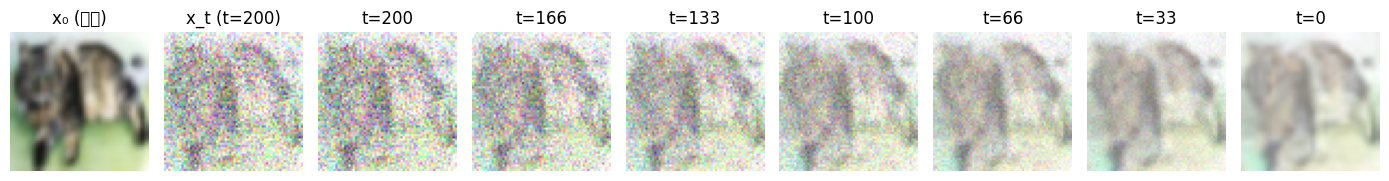

🖼️ 已儲存生成圖: /content/drive/MyDrive/ddpm_experiment/test_sample_t200.png


In [ ]:
# --- 測試 ---
import torch
import matplotlib.pyplot as plt
import random
from torchvision import transforms, datasets
from torchvision.utils import save_image

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🧪 Testing on device: {device}")

#載入模型
model = HeavyUNet(img_channels=3, base=base_channels, time_dim=time_dim).to(device)
model.load_state_dict(torch.load(save_path, map_location=device))
model.eval()
print(f"✅ 已載入模型權重：{save_path}")

#套用 EMA 權重
if use_ema and os.path.exists(ema_path):
    ema_state = torch.load(ema_path, map_location='cpu')
    ema.shadow = ema_state
    ema.apply_to(model)
    print("✅ 已套用 EMA 權重")

#取樣
transform = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor()])
dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
cat_indices = [i for i, label in enumerate(dataset.targets) if label == 3]
idx = random.choice(cat_indices)
x0, _ = dataset[idx]
x0 = x0.unsqueeze(0).to(device)
print(f"🐱 隨機選取第 {idx} 張貓圖")

#加噪
t_start = 200  # 步數
x_t = q_sample(x0, torch.tensor(t_start).to(device))  # 這裡不用傳 beta，因為函數裡已用全域變數 alpha_bar

#去噪
steps_to_show = [int(s) for s in torch.linspace(t_start, 0, 7)]
frames = []

with torch.no_grad():
    img = x_t.clone()
    for i in reversed(range(t_start+1)):
        t_tensor = torch.full((img.shape[0],), i, device=device)
        noise_pred = model(img, t_tensor)
        alpha_i = alpha[i]
        alpha_bar_i = alpha_bar[i]
        beta_i = beta[i]

        mean = (1 / alpha_i.sqrt()) * (img - (beta_i / (1 - alpha_bar_i).sqrt()) * noise_pred)
        if i > 0:
            z = torch.randn_like(img)
            img = mean + beta_i.sqrt() * z
        else:
            img = mean
        if i in steps_to_show:
            frames.append(img[0].clamp(-1, 1).cpu())

#結果
plt.figure(figsize=(14, 2))
plt.subplot(1, len(frames) + 2, 1)
plt.imshow(x0[0].permute(1, 2, 0).cpu())
plt.title("x₀ (原圖)")
plt.axis("off")

plt.subplot(1, len(frames) + 2, 2)
plt.imshow(((x_t.clamp(-1,1).cpu()[0] + 1) / 2).permute(1, 2, 0))
plt.title(f"x_t (t={t_start})")
plt.axis("off")

for i, f in enumerate(frames):
    plt.subplot(1, len(frames) + 2, i + 3)
    plt.imshow(((f + 1) / 2).permute(1, 2, 0))
    plt.title(f"t={steps_to_show[i]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

final_img = (img.clamp(-1,1) + 1) / 2
save_image(final_img, os.path.join(save_dir, f"test_sample_t{t_start}.png"))
print(f"🖼️ 已儲存生成圖: {os.path.join(save_dir, f'test_sample_t{t_start}.png')}")
